In [138]:
# import gpxpy
import fitparse
import matplotlib.pyplot as plt
import datetime
from geopy import distance, units
from math import sqrt, floor, log
import json
import simplejson
import types
import numpy as np
import pandas as pd
from haversine import haversine, Unit
from typing import List, Dict, Union, Tuple

In [139]:
pd.set_option('display.max_columns', 100)

In [140]:
#https://gis.stackexchange.com/questions/122186/convert-garmin-or-iphone-weird-gps-coordinates
COORD_CONST = 2**32 / 360

In [141]:
KM_PER_MILE = units.kilometers(miles=1)
METERS_PER_MILE = 1000*KM_PER_MILE
SECONDS_PER_MINUTE = 60
MINUTES_PER_HOUR = 60

In [142]:
KM_PER_MILE

1.609344

In [143]:
all_types = ['file_id', 'file_creator', 'event', 'device_info', 'sport', 'record', 'lap', 'session', 'activity']

In [144]:
fitfile = fitparse.FitFile('data/Garmin FIT Example.fit')
fitfile = fitparse.FitFile('data/Strava FIT Example.fit')
# fitfile = fitparse.FitFile('data/Morning_Run.fit')
# fitfile = fitparse.FitFile('data/Alex Marathon.fit')


messages = fitfile.get_messages()
sports = fitfile.get_messages('sport')
events = fitfile.get_messages('event')
records = fitfile.get_messages('records')

In [145]:
def create_json_from_messages(messages: object, chosen_type: str) -> List[Dict[str, Dict[str ,Union[str, int, float]]]]:
    chosen_type_list = []
    chosen_msgs = fitfile.get_messages(chosen_type)
    for chosen_msg in chosen_msgs:
        chosen_type_dict = {'type': chosen_type}
        data_dict = {}
        for data in chosen_msg:
            value = data.value
            if ('position_lat' in data.name or 'position_long' in data.name) and (abs(data.value) > 360): #Need to change values
                    value /= COORD_CONST
            data_dict[data.name] = value       
        chosen_type_dict['data'] = data_dict
        chosen_type_list.append(chosen_type_dict)
    
    return chosen_type_list

In [146]:
def create_df_from_json(chosen_type_list: List[Dict[str, Dict[str ,Union[str, int, float]]]]) -> pd.core.frame.DataFrame:
    # chosen_type_list = create_json_from_messages(messages, selected_type)
    df = pd.json_normalize(chosen_type_list, sep='_').dropna(axis='columns', how='all')

    return df

In [147]:
pd.read_json('Garmin Fitdump.json').type.unique()

array(['file_id', 'file_creator', 'unknown_79', 'event', 'device_info',
       'unknown_22', 'sport', 'record', 'unknown_104', 'lap',
       'unknown_140', 'session', 'unknown_113', 'activity'], dtype=object)

In [148]:
# def make_specific_json(messages: object, msg_tpe: str) -> List[Dict[str, Dict[str ,Union[str, int, float]]]]:

#     msg_type_json = create_json_from_messages(messages,msg_tpe)
#     # file_creator_json = create_json_from_messages(messages,'file_creator')
#     # event_json = create_json_from_messages(messages,'event')
#     # device_info_json = create_json_from_messages(messages,'device_info')
#     # sport_json = create_json_from_messages(messages,'sport')
#     # record_json = create_json_from_messages(messages,'record')
#     # lap_json = create_json_from_messages(messages,'lap')
#     # session_json = create_json_from_messages(messages,'session')
#     # activity_json = create_json_from_messages(messages,'activity')

#     return msg_type_json




In [149]:
jsons = {}
dfs = {}
for msg_type in all_types:
    jsons[msg_type] = create_json_from_messages(messages, msg_type)
    dfs[msg_type] = create_df_from_json(jsons[msg_type])

In [150]:
dfs['event']

,type,data_event,data_event_group,data_event_type,data_timer_trigger,data_timestamp,data_data
0,event,timer,0,start,manual,2021-03-14 17:14:38,NaN
1,event,timer,0,stop_all,manual,2021-03-14 18:35:31,NaN
2,event,session,1,stop_disable_all,NaN,2021-03-14 18:35:41,1.0


In [151]:
dfs['record']['data_position_long']

0      -73.949542
1      -73.949568
2      -73.949589
3      -73.949622
4      -73.949660
          ...    
4848   -73.949764
4849   -73.949652
4850   -73.949615
4851   -73.949577
4852   -73.949510
Name: data_position_long, Length: 4853, dtype: float64

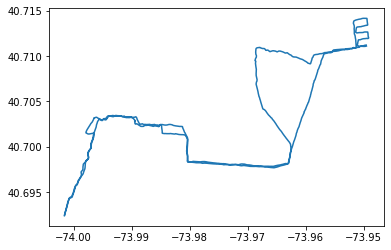

In [152]:
plt.plot(dfs['record']['data_position_long'], dfs['record']['data_position_lat'])

In [153]:
dfs['session']['data_total_distance_miles'] = dfs['session']['data_total_distance'] / METERS_PER_MILE

In [154]:
dfs['session']

,type,data_avg_heart_rate,data_avg_running_cadence,data_avg_speed,data_enhanced_avg_speed,data_event,data_event_type,data_first_lap_index,data_max_heart_rate,data_max_running_cadence,data_message_index,data_num_laps,data_sport,data_start_position_lat,data_start_position_long,data_start_time,data_sub_sport,data_timestamp,data_total_calories,data_total_distance,data_total_elapsed_time,data_total_strides,data_total_timer_time,data_trigger,data_total_distance_miles
0,session,159,81,3.328,3.328,lap,stop,0,177,89,0,11,running,40.711207,-73.949542,2021-03-14 17:14:38,generic,2021-03-14 18:35:41,1307,16150.14,4853.407,6383,4853.407,activity_end,10.035232


In [155]:
total_time_seconds = sum(dfs['session']['data_total_elapsed_time'])
total_distance_miles = sum(dfs['session']['data_total_distance_miles'])
avg_sec_per_mile = total_time_seconds / total_distance_miles
# avg_sec_per_mile = round(avg_sec_per_mile,2)
avg_min_per_mile = avg_sec_per_mile / SECONDS_PER_MINUTE
# avg_min_per_mile = round(avg_min_per_mile,2)

max_meters_per_second = dfs['record'].data_speed.max()
max_min_per_mile = METERS_PER_MILE / (max_meters_per_second*SECONDS_PER_MINUTE)

In [156]:
avg_min_per_mile

8.060612720186947

In [157]:
def convert_to_clock_time(display_format: str = 'hms', **kwargs) -> str:
    """
    Converts the number of minutes to a clock time

    Args:
        display_format (str, optional): Possible Formats for your time. Defaults to 'hours'. All Options:
        'hms' -> HH:MM:SS, 'hm' -> HH:MM, 'ms' -> MM:SS, 

    Returns:
        str: Clock Time, based on display_format param
    """
    orig_time = datetime.timedelta(**kwargs)
    second_offset = round(orig_time.microseconds/10**6) #1 if another second should be added, otherwise 0
    final_time = datetime.timedelta(seconds = orig_time.seconds+second_offset) #Add one second if microseconds round up
    clock_time = str(final_time).split('.')[0] #HH:MM:SS
    if len(clock_time) == 7: #H:MM:SS, add 0 to make consitent
        clock_time = '0'+clock_time
    if display_format == 'ms':
        clock_time = clock_time[-5:] #MM:SS
    elif display_format == 'hm':
        clock_time = clock_time[:5] #HH:MM

    return clock_time

In [158]:
clock_mile_pace = convert_to_clock_time('ms', minutes = avg_min_per_mile)

In [159]:
clock_max_mile_pace = convert_to_clock_time('ms', minutes = max_min_per_mile)

In [160]:
avg_heart_rate = dfs['session'].data_avg_heart_rate.mean()
avg_cadence = dfs['session'].data_avg_running_cadence.mean()

max_heart_rate = dfs['record'].data_heart_rate.max()
max_cadence = dfs['record'].data_cadence.max()

In [161]:
dfs['record']['min_per_mile'] = dfs['record'].apply(lambda x: 1/(x.data_speed * SECONDS_PER_MINUTE / METERS_PER_MILE),axis=1)

In [162]:
dfs['record']['clock_mile_pace'] = dfs['record']['min_per_mile'].apply(lambda x: convert_to_clock_time('ms',minutes=x))

In [163]:
dfs['record']['time_seconds'] = range(len(dfs['record']))

In [164]:
dfs['record']

,type,data_cadence,data_distance,data_enhanced_speed,data_heart_rate,data_position_lat,data_position_long,data_speed,data_timestamp,data_unknown_88,min_per_mile,clock_mile_pace,time_seconds
0,record,0,1.06,2.682,92,40.711207,-73.949542,2.682,2021-03-14 17:14:38,100,10.000895,10:00,0
1,record,0,3.31,2.596,91,40.711211,-73.949568,2.596,2021-03-14 17:14:39,100,10.332203,10:20,1
2,record,0,5.09,2.437,91,40.711207,-73.949589,2.437,2021-03-14 17:14:40,100,11.006319,11:00,2
3,record,0,7.88,2.513,90,40.711201,-73.949622,2.513,2021-03-14 17:14:41,100,10.673458,10:40,3
4,record,0,11.17,2.673,90,40.711193,-73.949660,2.673,2021-03-14 17:14:42,100,10.034568,10:02,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4848,record,79,16127.04,2.963,164,40.711062,-73.949764,2.963,2021-03-14 18:35:26,300,9.052447,09:03,4848
4849,record,79,16136.72,3.097,164,40.711080,-73.949652,3.097,2021-03-14 18:35:27,300,8.660768,08:40,4849
4850,record,79,16139.90,3.099,164,40.711085,-73.949615,3.099,2021-03-14 18:35:28,300,8.655179,08:39,4850
4851,record,79,16143.07,3.100,163,40.711088,-73.949577,3.100,2021-03-14 18:35:29,300,8.652387,08:39,4851


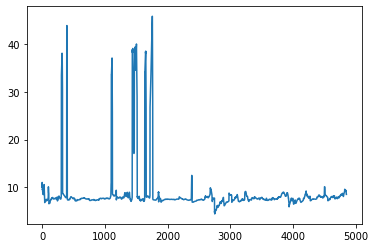

In [165]:
plt.plot(dfs['record']['time_seconds'],dfs['record']['min_per_mile'])

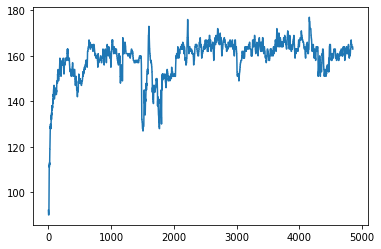

In [166]:
plt.plot(dfs['record']['time_seconds'],dfs['record']['data_heart_rate'])

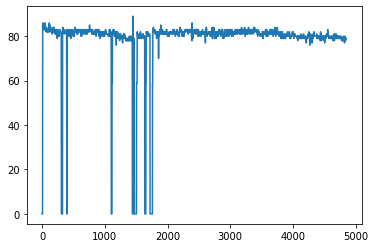

In [167]:
plt.plot(dfs['record']['time_seconds'],dfs['record']['data_cadence'])

In [168]:
dfs['record']['min_per_mile'].describe()

count    4853.000000
mean        8.686126
std         5.322603
min         4.408679
25%         7.356665
50%         7.589813
75%         7.959169
max        45.850256
Name: min_per_mile, dtype: float64

In [89]:
clock_mile_pace, clock_max_mile_pace, avg_heart_rate, max_heart_rate, avg_cadence*2, max_cadence*2

('08:04', '04:25', 159.0, 177, 162.0, 178)